# Crude oil production by state
> This notebook fetches, analyzes and visualizes oil production [data](https://www.eia.gov/petroleum/supply/annual/volume1/) from the US Energy Information Administration's annual petroleum supply report.

---

#### Import Python tools and Jupyter config

In [12]:
import us
import json
import math
import squarify
import warnings
import numpy as np
import pandas as pd
import jupyter_black
import altair as alt
import geopandas as gpd
from altair_cnn import theme
from vega_datasets import data
import matplotlib.pyplot as plt
from IPython.display import Image
from shapely.affinity import scale

In [13]:
jupyter_black.load()
pd.options.display.max_columns = 100
pd.options.display.max_rows = 100
pd.options.display.max_colwidth = None
alt.themes.register("altair_cnn", theme)
alt.themes.enable("altair_cnn")

ThemeRegistry.enable('altair_cnn')

In [14]:
# Suppress specific UserWarning from GeoPandas related to centroid calculations
warnings.filterwarnings(
    "ignore",
    "Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect.*",
    category=UserWarning,
)

---

## Fetch

#### Read [EIA data](https://www.eia.gov/petroleum/supply/annual/volume1/pdf/table14.pdf) on the production of crude by state, 2023

In [15]:
src = pd.read_csv(
    "https://www.eia.gov/petroleum/supply/annual/volume1/csv/table14.csv",
    encoding="latin-1",
)
src.columns = ["state", "total", "daily_avg"]

In [16]:
src["total"] = src["total"].str.replace(",", "").astype(int) * 1000
src["daily_avg"] = src["daily_avg"].str.replace(",", "").astype(int) * 1000

In [17]:
df = (
    src.query('~state.str.contains("District|Total|Slope")')
    .sort_values("total", ascending=False)
    .reset_index(drop=True)
)

In [18]:
# AP state names
name_to_ap = us.states.mapping("name", "ap_abbr")
df["place"] = df["state"].map(name_to_ap)

In [19]:
df["state_pct"] = round((df["total"] / df["total"].sum() * 100), 2)

In [20]:
df.head()

,state,total,daily_avg,place,state_pct
0,Texas,2011515000,5511000,Texas,49.78
1,New Mexico,665552000,1823000,N.M.,16.47
2,North Dakota,431716000,1183000,N.D.,10.68
3,Colorado,166790000,457000,Colo.,4.13
4,Oklahoma,156777000,430000,Okla.,3.88


---

## Treemap

#### Squarify state values

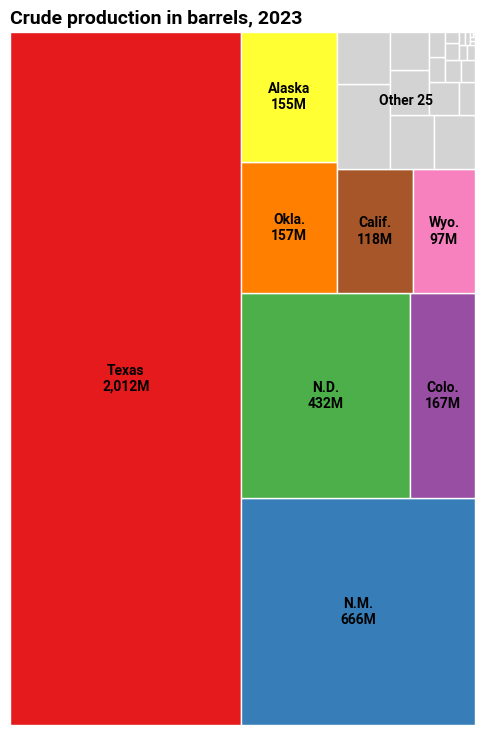

In [21]:
# Set global font properties
plt.rcParams.update(
    {"font.family": "Roboto", "font.size": 12, "font.weight": 500, "figure.dpi": 100}
)

df_sorted = df.sort_values(by="total", ascending=False).reset_index(drop=True)

# Label only the top 5 producers and add a label for the rest as "n other states"
top_n = 8
labels = [
    f"{place}\n{total / 1e6:,.0f}M" if idx < top_n else ""
    for idx, (place, total) in enumerate(zip(df_sorted["place"], df_sorted["total"]))
]

# Create color list: first top_n distinct colors, remaining with a neutral color
colors = [plt.cm.Set1(i) for i in range(top_n)] + ["#d3d3d3"] * (len(df_sorted) - top_n)

# Normalize the treemap layout using squarify
rects = squarify.normalize_sizes(df_sorted["total"], 100, 100)
rects = squarify.squarify(sizes=rects, x=0.0, y=0.0, dx=100.0, dy=100.0)

# Treemap plotting with borders
fig, ax = plt.subplots(figsize=(6, 9))

# Draw each rectangle
other_states_area = None  # Variable to hold the combined area of other states
for idx, (rect, color, label) in enumerate(zip(rects, colors, labels)):
    x, y, dx, dy = rect["x"], rect["y"], rect["dx"], rect["dy"]
    ax.add_patch(plt.Rectangle((x, y), dx, dy, color=color, ec="white", lw=1))
    if idx == top_n:  # Start tracking the combined area for "other states"
        other_states_area = {"x": x, "y": y, "dx": dx, "dy": dy}
    elif idx > top_n and other_states_area:
        # Expand the combined area
        other_states_area["dx"] = (
            max(other_states_area["x"] + other_states_area["dx"], x + dx)
            - other_states_area["x"]
        )
        other_states_area["dy"] = (
            max(other_states_area["y"] + other_states_area["dy"], y + dy)
            - other_states_area["y"]
        )
    if label:
        ax.text(
            x + dx / 2,
            y + dy / 2,
            label,
            ha="center",
            va="center",
            fontsize=10,
            weight="bold",
            antialiased=True,
        )

# Add a centered label for "other states"
if other_states_area:
    center_x = other_states_area["x"] + other_states_area["dx"] / 2
    center_y = other_states_area["y"] + other_states_area["dy"] / 2
    ax.text(
        center_x,
        center_y,
        f"Other {len(df_sorted) - top_n}",
        ha="center",
        va="center",
        fontsize=10,
        weight="bold",
        antialiased=True,
    )

# Set limits and remove axes
ax.set_xlim(0, 100)
ax.set_ylim(0, 100)
ax.axis("off")

# Set title
plt.title(
    "Crude production in barrels, 2023", loc="left", fontsize=14, fontweight="bold"
)

plt.show()

---

## Map

#### Proportional symbols

In [11]:
# Load US states as a GeoDataFrame and keep in EPSG:4326 for compatibility with Altair
us_states_src = gpd.read_file(
    "https://stilesdata.com/gis/usa_states_esri_simple.json"
)  # Ensure we are using EPSG:4326 for compatibility with Altair
us_states_src.columns = us_states_src.columns.str.lower()

# Merge the data and fill missing values
us_states = us_states_src.merge(df, left_on="state_name", right_on="state", how="left")
us_states["total"] = us_states["total"].fillna(0)

# Calculate centroids in the projected CRS for accuracy
us_states["centroid"] = us_states.geometry.centroid
us_states["longitude"] = us_states["centroid"].x
us_states["latitude"] = us_states["centroid"].y

# Convert GeoDataFrame to GeoJSON for Altair (without centroids)
us_states_json = json.loads(us_states.drop(columns="centroid").to_json())

# Prepare the base map of US states using Altair
background = (
    alt.Chart(alt.topo_feature(data.us_10m.url, feature="states"))
    .mark_geoshape(fill="#ededed", stroke="white")
    .properties(width=500, height=300, title="Crude production in barrels, 2023")
    .project("albersUsa")
)

# Convert the data for symbols into a Pandas DataFrame for Altair
us_states_df = us_states[["state", "longitude", "latitude", "total", "place"]]

# Set the size range for circles based on the total production
min_value = math.sqrt(us_states_df["total"].min()) / 3
max_value = math.sqrt(us_states_df["total"].max()) / 3

# Prepare the symbols representing oil production
symbols = (
    alt.Chart(us_states_df)
    .mark_circle(opacity=0.5)
    .encode(
        longitude="longitude:Q",
        latitude="latitude:Q",
        size=alt.Size(
            "total:Q",
            scale=alt.Scale(range=[min_value, max_value]),
            legend=None,
        ),
        color=alt.value("#e41a1d"),
    )
    .project("albersUsa")  # Ensure the projection matches the base map
)

# Prepare the state labels on top of the symbols
labels = (
    alt.Chart(us_states_df.query("total>0"))
    .mark_text(
        dy=-10, fontSize=10, fontWeight="normal", color="black"
    )  # Adjust 'dy' for label position
    .encode(
        longitude="longitude:Q",
        latitude="latitude:Q",
        text="place:N",  # Use the state abbreviation as the label
    )
    .project("albersUsa")  # Ensure the projection matches the base map
)

# Combine the background, symbols, and labels
symbol_map = background + symbols + labels
symbol_map.configure_view(stroke=None)
symbol_map.save("visuals/map.png")

# Display the map
symbol_map

alt.LayerChart(...)